In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler, KBinsDiscretizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, KFold, GridSearchCV, RepeatedKFold
from itertools import combinations
from tqdm.notebook import tqdm
from rfpimp import permutation_importances
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from catboost import CatBoostRegressor
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
import optuna
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, BinaryEncoder, JamesSteinEncoder, WOEEncoder, TargetEncoder
from scipy.stats import chi2_contingency
from feature_engine.encoding import PRatioEncoder, MeanEncoder
from sklearn.decomposition import NMF
from rfpimp import permutation_importances
from feature_engine.outliers import Winsorizer
from scipy.stats import spearmanr
pd.set_option("display.max_columns", 1000)

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

In [3]:
train.Price = np.log(train.Price)

In [4]:
df = pd.concat([train, test], axis=0)

In [5]:
df.Levy = df.Levy.astype(str).replace('-', 0)
df.Levy = df.Levy.astype(int)

In [6]:
#df.Levy.fillna(value=df.Levy.median(), inplace=True, axis=0)

In [7]:
df.Mileage = df.Mileage.str.split(' ', expand=True)[0]
df.Mileage = df.Mileage.astype(int)

<AxesSubplot:>

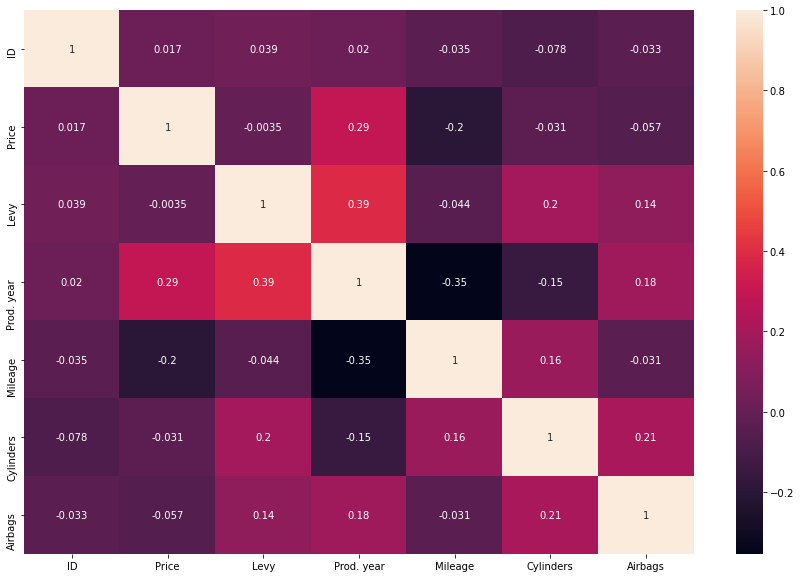

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr('spearman'), annot=True)

In [9]:
df.Wheel.unique()

array(['Left wheel', 'Right-hand drive'], dtype=object)

In [10]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,9.497622,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,9.718422,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,9.043932,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,8.190632,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,9.369564,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [11]:
df['airbags_id_max']= df.groupby(['Airbags'])['ID'].transform('max')

In [12]:
df['mil_id_cnt']= df.groupby(['Mileage'])['ID'].transform('count')

In [13]:
df['milsssssssss']= df.groupby(['Model'])['Mileage'].transform('mean')
df['airrrrrrrrrr']= df.groupby(['Model'])['Airbags'].transform('median')

In [14]:
df['miles'] = df.Mileage * 0.621371

In [ ]:
df.nunique(), df.shape

In [ ]:
[var for var in df.columns if df[var].dtypes == 'O']

In [ ]:
columns=['Leather interior',
 'Gear box type',
 'Prod. year',
 'Airbags']
comb = combinations(columns,2)
for i in list(comb):
    df[f'{i[0]}_{i[1]}']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)

In [15]:
df['Turbo or Non-Turbo']=df['Engine volume'].replace(['2.0 Turbo','2.2 Turbo','3.0 Turbo','1.4 Turbo','1.5 Turbo', '1.6 Turbo',
                                                                    '2.3 Turbo','2.8 Turbo','1.8 Turbo', '2.4 Turbo', '3.5 Turbo', '3.2 Turbo',
                                                                    '1.3 Turbo','2.5 Turbo','1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.2 Turbo',
                                                                    '4.8 Turbo','4.6 Turbo','1.2 Turbo','1.7 Turbo', '6.3 Turbo', '2.7 Turbo',
                                                                    '2.9 Turbo', '4.0 Turbo','3.6 Turbo','3.7 Turbo','5.5 Turbo','2.1 Turbo',
                                                                    '0.7 Turbo', '0.6 Turbo','1.0 Turbo', '4.5 Turbo', '0.8 Turbo', '4.2 Turbo','6.0 Turbo',
                                                                    '2.6 Turbo',
                                                                    '3.1', '5.0 Turbo','5.7 Turbo','0.4 Turbo', '5.4 Turbo', '0.3 Turbo','1.1 Turbo'],'Turbo')

In [16]:
df['Turbo or Non-Turbo']=df['Turbo or Non-Turbo'].replace(['3.5','3','1.3','2.5','2','1.8','2.4','4','1.6','3.3','4.7','1.5','4.4','3.6','2.3','2.2','1.4',
                                                                    '5.5','3.2','3.8','4.6','1.2','5', '1.7', '2.9', '0.5','1.9','2.7','4.8','5.3','0.4','2.8','1.1',
                                                                    '2.1','0.7','5.4','3.7','1','2.6','5.7','3.4','4.3','4.2','5.9','6.8','4.5','0.6','7.3','0.1','6.3',
                                                                    '6.4','6.1','10.8','6.6','5.2','5.8','0.8', '6.7', '6.2','0', '20', '0.3', '0.2','5.6', '6', '3.9', '0.9'],'Non-Turbo')

In [17]:
df['Engine volume']=df['Engine volume'].str.replace('Turbo',' ')

In [18]:
df['Engine volume']=df['Engine volume'].astype(float)

In [19]:
cat_cols= ['Manufacturer',
 'Model',
 'Prod. year',
 'Engine volume']

In [20]:
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)

In [21]:
cylin = pd.get_dummies(df['Cylinders'], drop_first=True, prefix= 'cylinders_')
df = df.drop('Cylinders', axis= 1)
df = pd.concat([df, cylin], axis= 1)

In [22]:
turbo = pd.get_dummies(df['Turbo or Non-Turbo'], drop_first=True, prefix= 'turbo_')
df = df.drop('Turbo or Non-Turbo', axis= 1)
df = pd.concat([df, turbo], axis= 1)

In [23]:
wheels = pd.get_dummies(df['Drive wheels'], drop_first=True, prefix= 'drive_')
df = df.drop('Drive wheels', axis= 1)
df = pd.concat([df, wheels], axis= 1)

In [24]:
cats = pd.get_dummies(df.Category, drop_first=True, prefix= 'cat_')
df = df.drop('Category', axis= 1)
df = pd.concat([df, cats], axis= 1)

In [25]:
fuel = pd.get_dummies(df['Fuel type'], drop_first=True, prefix= 'fuel_')
df = df.drop('Fuel type', axis= 1)
df = pd.concat([df, fuel], axis= 1)

In [26]:
gears = pd.get_dummies(df['Gear box type'], drop_first=True, prefix= 'gears_')
df = df.drop('Gear box type', axis= 1)
df = pd.concat([df, gears], axis= 1)

In [27]:
door = pd.get_dummies(df.Doors, drop_first=True, prefix= 'door_')
df = df.drop('Doors', axis= 1)
df = pd.concat([df, door], axis= 1)

In [28]:
wheel = pd.get_dummies(df.Wheel, drop_first=True, prefix= 'wheel_')
df = df.drop('Wheel', axis= 1)
df = pd.concat([df, wheel], axis= 1)

In [29]:
color = pd.get_dummies(df.Color, drop_first=True, prefix= 'col_')
df = df.drop('Color', axis= 1)
df = pd.concat([df, color], axis= 1)

In [30]:
air = pd.get_dummies(df.Airbags, drop_first=True, prefix= 'air_')
df = df.drop('Airbags', axis= 1)
df = pd.concat([df, air], axis= 1)

In [31]:
sc = LabelEncoder()
sc.fit(df['Leather interior'])
df['Leather interior']= sc.transform(df['Leather interior'])

In [ ]:
df

In [ ]:
[var for var in df.columns if df[var].dtypes == 'O']

In [32]:
train = df[:19237]
test = df[19237:]

In [ ]:
from category_encoders import CatBoostEncoder, BaseNEncoder
asd = BaseNEncoder(cols=[
 'Category',
 'Leather interior',
 'Fuel type',
 'Engine volume',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color'], base=2)
asd.fit(train)
train = asd.transform(train)
test = asd.transform(test)

In [ ]:
[var for var in train.columns if train[var].dtypes != 'O']

In [33]:
cont_cols= ['ID',
 'Levy',
 'Manufacturer',
 'Model',
 'Prod. year',
 'Leather interior',
 'Engine volume',
 'Mileage',
 'airbags_id_max',
 'mil_id_cnt',
 'milsssssssss',
 'airrrrrrrrrr',
 'miles',
 'cylinders__2.0',
 'cylinders__3.0',
 'cylinders__4.0',
 'cylinders__5.0',
 'cylinders__6.0',
 'cylinders__7.0',
 'cylinders__8.0',
 'cylinders__9.0',
 'cylinders__10.0',
 'cylinders__11.0',
 'cylinders__12.0',
 'cylinders__14.0',
 'cylinders__15.0',
 'cylinders__16.0',
 'cylinders__127.0',
 'turbo__Turbo',
 'drive__Front',
 'drive__Rear',
 'cat__Coupe',
 'cat__Goods wagon',
 'cat__Hatchback',
 'cat__Jeep',
 'cat__Limousine',
 'cat__Microbus',
 'cat__Minivan',
 'cat__Pickup',
 'cat__Sedan',
 'cat__Universal',
 'fuel__Diesel',
 'fuel__Hybrid',
 'fuel__Hydrogen',
 'fuel__LPG',
 'fuel__Petrol',
 'fuel__Plug-in Hybrid',
 'gears__Manual',
 'gears__Tiptronic',
 'gears__Variator',
 'door__04-May',
 'door__>5',
 'wheel__Right-hand drive',
 'col__Black',
 'col__Blue',
 'col__Brown',
 'col__Carnelian red',
 'col__Golden',
 'col__Green',
 'col__Grey',
 'col__Orange',
 'col__Pink',
 'col__Purple',
 'col__Red',
 'col__Silver',
 'col__Sky blue',
 'col__White',
 'col__Yellow',
 'air__1',
 'air__2',
 'air__3',
 'air__4',
 'air__5',
 'air__6',
 'air__7',
 'air__8',
 'air__9',
 'air__10',
 'air__11',
 'air__12',
 'air__13',
 'air__14',
 'air__15',
 'air__16']

In [45]:
X_train = train[cont_cols]
y_train = train.Price
X_test = test[cont_cols]

In [41]:
X = train[cont_cols]
y = train.Price

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [46]:
win = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Levy', 'Mileage'])
win.fit(X_train)
X_train = win.transform(X_train)

In [47]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = RandomForestRegressor(criterion='mse', random_state=10, n_estimators= 2500, **rfc_params)
    model.fit(X_tr, y_tr)
    print(np.sqrt(mean_squared_log_error(np.exp(y_tst), np.exp(model.predict(X_tst)))))
    subbed.append(np.sqrt(mean_squared_log_error(np.exp(y_tst), np.exp(model.predict(X_tst)))))
    pred = model.predict(X_test)
print('Final output===: ',np.mean(subbed))
#Final output===:  0.93782

=============== Fold No: 1 ===============
0.7744359649228914
=============== Fold No: 2 ===============
0.8267992330234278
=============== Fold No: 3 ===============
0.8023704199437458
=============== Fold No: 4 ===============
0.763225310034834
=============== Fold No: 5 ===============
0.8006256023904951
=============== Fold No: 6 ===============
0.8404441130574148
=============== Fold No: 7 ===============
0.8436199581823899
=============== Fold No: 8 ===============
0.9556411646266737
=============== Fold No: 9 ===============
0.8579859638346168
=============== Fold No: 10 ===============
0.815364023944616
Final output===:  0.8280511753961106


In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=0))

# train Lasso model and select features
sel_.fit(X_train, y_train)

In [ ]:
# this is how we can make a list of the selected features
selected_feats = X_train.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

In [ ]:
sel_.get_support()

In [ ]:
# print the selected features
selected_feats

In [ ]:
selected_feats = X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

selected_feats

In [36]:
rfc_params = {'max_depth': 42,
 'min_samples_split': 3,
 'max_features': 'sqrt',
 'bootstrap': False}

ext_params= {'max_depth': 37,
 'min_samples_split': 6,
 'max_features': 'auto',
 'bootstrap': False}

In [ ]:
models = [ExtraTreesRegressor(criterion='mse',**ext_params,random_state=10), RandomForestRegressor(criterion='mse',**rfc_params,random_state=10)]
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('Model:', model, 'Gives best score of:', np.sqrt(mean_squared_log_error(np.exp(y_test), np.round(np.exp(pred)))))

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=10)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'max_depth': trial.suggest_int('max_depth', 1,75),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 75),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])}
    
    mod = RandomForestRegressor(criterion='mse', n_jobs=-1, **param, random_state=10)
    mod.fit(train_x, train_y)
    return np.sqrt(mean_squared_log_error(np.exp(test_y), np.round(np.exp(mod.predict(test_x)))))

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.best_params

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [ ]:
def r2(rf, X_train, y_train):
    return np.sqrt(mean_squared_log_error(np.exp(y_train), np.round(np.exp(model.predict(X_train)))))

perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

In [ ]:
var_imp_plot(perm_imp_rfpimp)

In [39]:
predict = np.round(np.exp(pred))

In [40]:
sub = pd.DataFrame()
sub['Price'] = predict
sub.to_csv('31th_rfc.csv', index= False)